
# Stock Price Prediction using Support Vector Machine - Regression (SVR)

This study uses a machine learning technique called **Support Vector Regression(SVR)** to predict stock prices for large and small capitalisations.





### **Data Set**

**YFinace** is used here as it allows users to download data using python and it has some great features also which makes it favourable to use for **stock data analysis**. YFinance not only downloads the Stock Price data it also allows us to download all the financial data of a Company since its listing in the stock market. 

# Installation 
Install yfinance using pip:

In [67]:
!pip3 install yfinance

## Import dependencies

In [68]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

## Selecting the Stock by its Symbol

In [69]:
stock_symbol = 'MSFT'
data = yf.Ticker(stock_symbol)
historical_data = data.history(period="5y")
ohlc_avg = pd.DataFrame(historical_data.iloc[:, 0:4].mean(axis=1), columns=['OHLC_avg'])



## Split dataset into training and testing dataset
 Data older than 90 days is training dataset and remaining is testing dataset , but since some of the data are missing there is a total of nearly 60 days

In [70]:

testing_dataframe = ohlc_avg[ohlc_avg.index > datetime.utcnow() - pd.to_timedelta('90days')]
training_dataframe = ohlc_avg[ohlc_avg.index < testing_dataframe.index[0]]
print('training set shape:', training_dataframe.shape)
print('testing set shape:', testing_dataframe.shape)

training set shape: (1197, 1)
testing set shape: (61, 1)


## Plotting graph between Test and Train Data set

In [71]:
def plot_training_testing_distribution(symbol, training_df, testing_df):
    plt.plot(testing_df, color = 'red', label = 'Testing dataset')
    plt.plot(training_df, color = 'blue', label = 'Training dataset')
    plt.title('{} Stock Dataset'.format(symbol))
    plt.xlabel('Time')
    plt.ylabel('{} Stock Price'.format(symbol))
    plt.legend()
    plt.xticks(rotation='vertical')
    plt.show()

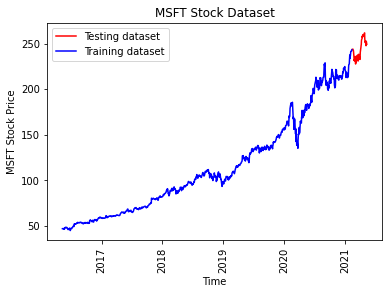

In [72]:
plot_training_testing_distribution(stock_symbol, training_dataframe, testing_dataframe)

## Scaling the data to include it in a range of 0-1
Change features to numpy arrays and check the shapes

In [73]:
training_dataset = training_dataframe.values
transformer = MinMaxScaler(feature_range = (0, 1))
training_dataset_scaled_x = transformer.fit_transform(training_dataset)

training_dataset_scaled_y = training_dataset_scaled_x

X_train = []
y_train = []

for i in range(60, len(training_dataset_scaled_x)):
    X_train.append(training_dataset_scaled_x[i-60:i, :])
    y_train.append(training_dataset_scaled_y[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

## Checking Shapes

In [74]:
X_train = X_train.reshape(X_train.shape[0], -1)

In [75]:
X_train.shape

(1137, 60)

In [76]:
y_train.shape

(1137,)

In [77]:
print(X_train[1][59],y_train[0])

0.04258168230134318 0.04258168230134318


# Create and train the Support Vector Machine (Regressor)

In [78]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

In [79]:
#  Support Vector Machine (Regressor) 
stock_prediction_model = SVR(kernel='linear', C=1e3, gamma=0.1) 
stock_prediction_model.fit(X_train, y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#Predicting Buy/Sell
Here we are comparing the predicted stock price of the next day (day 61) with the mean of ohlc (Open,High,Low,Close) of previous 60 days

In [80]:
def find_buy_sell(historical_ohlc_avg, next_day_prediction):
  mean_of_historical_ohlc_avg = historical_ohlc_avg.mean()[0]
  if next_day_prediction > mean_of_historical_ohlc_avg:
    return 'buy'
  elif next_day_prediction < mean_of_historical_ohlc_avg:
    return 'sell'
  else:
    return 'hold'

##Displaying favourable days to **Buy and Sell**, and also comparing with the actual stock price of the predicted days

In [81]:
real_stock_price = testing_dataframe.iloc[:, 0:1].values
predicted_stock_price = []
look_ahead_predicted_stock_price = []
predicted_stock_price_scaled = []

inputs = ohlc_avg[len(ohlc_avg) - len(testing_dataframe) - 60:].values
inputs = transformer.transform(inputs)
real_stock_price_scaled = transformer.transform(real_stock_price)
correct = wrong = total = 0

for i in range(60, len(inputs)):
    next_day_input = inputs[i-60:i, :]
    next_day_input = next_day_input.reshape(1, 60, 1)
    next_day_input = next_day_input.reshape(next_day_input.shape[0], -1)
    next_day_predicted_stock_price = stock_prediction_model.predict(next_day_input)
    predicted_stock_price_scaled.append(next_day_predicted_stock_price) 
    next_day_predicted_stock_price = transformer.inverse_transform(next_day_predicted_stock_price.reshape(-1,1))
    predicted_stock_price.append(next_day_predicted_stock_price[0][0])
    prediction = find_buy_sell(ohlc_avg[len(training_dataframe) + i - 60 - 60:len(training_dataframe) + i - 60], next_day_predicted_stock_price[0][0])
    print('Prediction: Tomorrow (utc:{}) it is more favourable to {}'.format(str(testing_dataframe.index[i-60].date()), prediction))
    real = find_buy_sell(ohlc_avg[len(training_dataframe) + i - 60 - 60:len(training_dataframe) + i - 60], real_stock_price[i-60])
    if prediction != real:
        wrong += 1
    else:
        correct += 1
    total += 1

print("Correct predictions:", correct)
print("Wrong predictions:", wrong)

print("Correct predictions percentage: {}%\n".format(round(correct*100/total, 2)))

Prediction: Tomorrow (utc:2021-02-11) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-12) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-16) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-17) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-18) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-19) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-22) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-23) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-24) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-25) it is more favourable to buy
Prediction: Tomorrow (utc:2021-02-26) it is more favourable to buy
Prediction: Tomorrow (utc:2021-03-01) it is more favourable to buy
Prediction: Tomorrow (utc:2021-03-02) it is more favourable to buy
Prediction: Tomorrow (utc:2021-03-03) it is more favourable to buy
Prediction: Tomorrow (utc:2021-03-04) it is more favourable to

In [82]:
from sklearn.metrics import mean_squared_error

## Finding Root Mean Square (**RMSE**) for original values

In [83]:
mse=mean_squared_error(real_stock_price,predicted_stock_price)
rmse=np.sqrt(mse)
print('RMSE for Original values :',rmse)

RMSE for Original values : 9.0609249360998


In [84]:
mse_scaled=mean_squared_error(real_stock_price_scaled,predicted_stock_price_scaled)
rmse_scaled=np.sqrt(mse_scaled)
print('RMSE for Scaled values :',rmse_scaled)


RMSE for Scaled values : 0.04572824772627364


In [85]:
look_ahead_predicted_stock_price_scaled=[]
for i in range(60, len(inputs)):
    next_day_input = inputs[i-60:i, :]
    next_day_input = next_day_input.reshape(1, 60, 1)
    next_day_input = next_day_input.reshape(next_day_input.shape[0], -1)
    next_day_predicted_stock_price = stock_prediction_model.predict(next_day_input)
    look_ahead_predicted_stock_price_scaled.append(next_day_predicted_stock_price)
    next_day_predicted_stock_price = transformer.inverse_transform(next_day_predicted_stock_price.reshape(-1,1))
    look_ahead_predicted_stock_price.append(next_day_predicted_stock_price[0][0])
    inputs[i] = next_day_predicted_stock_price[0][0]
    prediction = find_buy_sell(ohlc_avg[len(training_dataframe) + i - 60 - 60:len(training_dataframe) + i - 60], next_day_predicted_stock_price[0][0])
    

# Plotting Real Stock Price v/s Predicted Stock Price 

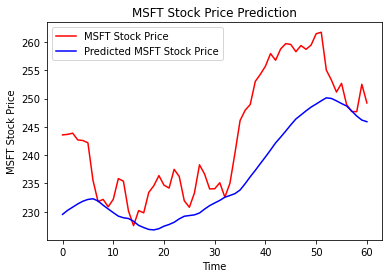

In [86]:
plt.plot(real_stock_price, color = 'red',label = '{} Stock Price'.format(stock_symbol))
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted {} Stock Price'.format((stock_symbol)))
plt.title('{} Stock Price Prediction'.format(stock_symbol))
plt.xlabel('Time')
plt.ylabel('{} Stock Price'.format(stock_symbol))
plt.legend()
plt.savefig('graph.png')
plt.show()

Graph to show the values obtained after using Predicted values to predicted next day Stock

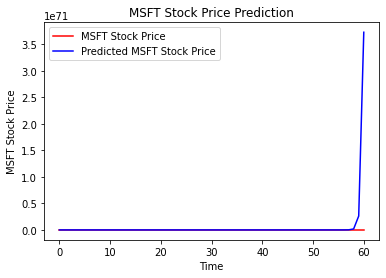

In [91]:
# plt.plot(real_stock_price, color = 'red', label = '{} Stock Price'.format(stock_symbol))
# plt.plot(look_ahead_predicted_stock_price, color = 'blue', label = 'Predicted {} Stock Price'.format((stock_symbol)))
# plt.title('{} Stock Price Prediction'.format(stock_symbol))
# plt.xlabel('Time')
# plt.ylabel('{} Stock Price'.format(stock_symbol))
# plt.legend()
# plt.savefig('graph1.png')
# plt.show()